In [1]:
import pandas as pd
import numpy as np

# Read data

In [2]:
items = pd.read_excel('office-products.xlsx', sheet_name='Items', index_col=0)
ratings = pd.read_excel('office-products.xlsx', sheet_name='Ratings', index_col=0)
cbf = pd.read_excel('office-products.xlsx', sheet_name='CBF', index_col=0)
item_item = pd.read_excel('office-products.xlsx', sheet_name='Item-Item', index_col=0)
mf = pd.read_excel('office-products.xlsx', sheet_name='MF', index_col=0)
pers_bias = pd.read_excel('office-products.xlsx', sheet_name='PersBias', index_col=0)
user_user = pd.read_excel('office-products.xlsx', sheet_name='User-User', index_col=0)

In [3]:
print('items shape : ' + str(items.shape))
print('ratings shape : ' + str(ratings.shape))
print('cbf shape : ' + str(cbf.shape))
print('item_item shape : ' + str(item_item.shape))
print('mf shape : ' + str(mf.shape))
print('pers_bias shape : ' + str(pers_bias.shape))
print('user_user shape : ' + str(user_user.shape))

items shape : (200, 7)
ratings shape : (200, 100)
cbf shape : (200, 100)
item_item shape : (200, 100)
mf shape : (200, 100)
pers_bias shape : (200, 100)
user_user shape : (200, 100)


# Summary

Ratings df will become observed values / ground truth values
Other values from different methods will become out prediction values

Evaluation metrics : RMSE, NDCG and Precision@N



In [4]:
class Model:
    
    def __init__(self, items, ratings, cbf, item_item, mf, pers_bias, user_user):
        
        self.items = items
        self.ratings = ratings
        self.cbf = cbf
        self.item_item = item_item
        self.mf = mf
        self.pers_bias = pers_bias
        self.user_user = user_user
        
        # avg rating for user
        self.avgUserRating = ratings.apply(lambda x: np.average(x[~np.isnan(x)]))
        
        # combine lists for clear code
        self.RCList = [self.cbf, self.item_item, self.mf, self.pers_bias,self.user_user]
        self.RCListNames = ['cbf', 'item_item', 'mf', 'pers_bias','user_user']
        
        # Item popularity values
        topNItem = 25
        itemBoughtPercentage = self.ratings.apply(lambda x: np.sum(~np.isnan(x)), axis=0) / ratings.shape[1]
        tmp_sorted = np.argsort(itemBoughtPercentage)[::-1]
        self.popularItems = itemBoughtPercentage.iloc[tmp_sorted][:topNItem].index.values.astype(np.int)
    
    
    # Returns all ratings for specific user
    def getRatings(self, user_user_id):
        filteredRatings = self.ratings[str(user_user_id)]
        return filteredRatings[~np.isnan(filteredRatings)]
    
    # Returns top n ratings for each recommender
    def getTopNRecommendation(self, user_user_id, topNRecomm):
        topNRecommendation = dict()
        
        for i, j in zip(self.RCList,self.RCListNames):
            itemIdList = i[str(user_user_id)].argsort().sort_values()[:topNRecomm].index.values
            topNRecommendation[j] = itemIdList
        return topNRecommendation
    
    # Calculates RMSE error between ratings and RCList predictions, Returns DataFrame
    def rmse(self, user_user_id):
        userRatings = self.getRatings(str(user_user_id))
        rmse = []
        
        for i in self.RCList:
            pred = i.reindex(index = userRatings.index)[str(user_user_id)]
            rmse.append(np.sqrt(np.average(np.power((pred - userRatings), 2))))
            
        rmseDF = pd.DataFrame({'rmse' : rmse}, index = self.RCListNames)
        return rmseDF
    
    
    # Normalized Discounted Cumulative Gain for RCList
    def NDCG(self, user_user_id, topN = 5, indvRecommendation=None):
        
        userRatings = self.getRatings(user_user_id)
        
        if indvRecommendation is None:
            topNRecommendation = self.getTopNRecommendation(user_user_id, topN)
            resultsIndex = self.RCListNames
        else:
            topNRecommendation = indvRecommendation
            resultsIndex = list(indvRecommendation.keys())

        # Converts recommendations into scores
        allScores = []
        for name, itemList in topNRecommendation.items():
            scores = np.empty_like(itemList)
            scores[:] = -15                 
            ratedUsers = np.isin(itemList, userRatings.index.values)
            scores[~ratedUsers] = 0
            
            for idx, score in enumerate(scores):
                if(score != 0):
                    if(userRatings[itemList[idx]] < self.avgUserRating[user_user_id] - 1):
                        scores[idx] = -1
                    elif((userRatings[itemList[idx]] >= self.avgUserRating[user_user_id] - 1) & 
                         (userRatings[itemList[idx]] < self.avgUserRating[user_user_id] + 0.5)):
                        scores[idx] = 1
                    else:
                        scores[idx] = 2
            
            allScores.append(scores)                             

        # Calculates DCG, ideal DCG and NDCG with scores
        allNDCG = {}
        
        for idx, scores in enumerate(allScores):   
            DCG = 0    
            
            for scoreIdx, score in enumerate(scores):                                  
                DCG = DCG + score/np.log2(scoreIdx + 2) 
                
            idealItems = np.sort(scores)[::-1]                        
            idealDCG = 0
            
            for idealItemsIdx, idealScore in enumerate(idealItems):                                                           
                idealDCG = idealDCG + idealScore/np.log2(idealItemsIdx + 2) 
            
            if (idealDCG == 0) or (np.abs(idealDCG) < np.abs(DCG)):
                NDCG = 0 
            else:                                                    
                NDCG = DCG / idealDCG
                                                         
            allNDCG[resultsIndex[idx]] = NDCG
            
            result = pd.DataFrame(allNDCG, index=range(1)).transpose()
            result.columns = ['NDCG']
            
        return result

    
    # Calculates column stats(std and mean for 'Price' and 'Availability')
    def calcStats(self, user_user_id, column, topN=5, indvRecommendation = None):
        
        if(indvRecommendation is None):
            topNRecommendation = self.getTopNRecommendation(user_user_id, topN)
        else:
            topNRecommendation = indvRecommendation

        
        stats = pd.DataFrame()
        
        for k, _ in topNRecommendation.items():
            filteredData = self.items.loc[topNRecommendation[k]][[column]].agg(['mean','std']).transpose()
            filteredData.index = [k]
            stats = stats.append(filteredData)
        
        return stats
    
    
    # Returns the ratio of the top n items are among the most popular items.
    def popularity(self, user_user_id, topN=5, indvRecommendation = None):
        
        if(indvRecommendation is None):
            topNRecommendation = self.getTopNRecommendation(user_user_id, topN)
            resultsIndex = self.RCListNames
        else:
            topNRecommendation = indvRecommendation
            resultsIndex = list(indvRecommendation.keys())

        results = []
        
        for recommender, recommendations in topNRecommendation.items():
            popularity = np.sum(np.isin(recommendations,self.popularItems))
            results.append(popularity)
        
        return pd.DataFrame({'popularity' : results},index = resultsIndex)
    
    
    # Calculates precision@N
    def precision_at_n(self, user_user_id, topN=10, indvRecommendation = None):
        
        if(indvRecommendation is None):
            topNRecommendation = self.getTopNRecommendation(user_user_id, topN)
            resultsIndex = self.RCListNames
        else:
            topNRecommendation = indvRecommendation
            resultsIndex = list(indvRecommendation.keys())
        
        observed_ratings = self.getRatings(user_user_id).index.values
        precisions = []
        
        for recommender, recommendations in topNRecommendation.items():
            precisions.append(np.sum(np.isin(recommendations, observed_ratings)) / topN)
        
        return pd.DataFrame({'precision_at_' + str(topN): precisions}, index = resultsIndex)

# Analysis for user 252

In [5]:
# init model
userId = '252'
model = Model(items, ratings, cbf, item_item, mf, pers_bias, user_user)

### Best method is User-User Collaborative Filtering according to RMSE values 

In [6]:
model.rmse(userId)

,rmse
cbf,0.756997
item_item,0.604561
mf,0.913888
pers_bias,0.925349
user_user,0.602597


### NDCG values 

In [7]:
model.NDCG(userId)

,NDCG
cbf,0.00000
item_item,1.00000
mf,0.50000
pers_bias,0.50000
user_user,0.63093


### Stats for Price

In [8]:
model.calcStats(userId, 'Price')

,mean,std
cbf,24.656,38.458336
item_item,10.186,4.635135
mf,12.782,4.439287
pers_bias,9.890,5.121875
user_user,54.122,87.438822


### Stats for Availability

In [9]:
model.calcStats(userId, 'Availability')

,mean,std
cbf,0.513279,0.241932
item_item,0.648397,0.248696
mf,0.559237,0.238622
pers_bias,0.588596,0.172630
user_user,0.553433,0.128046


### Popularity values

In [10]:
model.popularity(userId)

,popularity
cbf,0
item_item,0
mf,0
pers_bias,0
user_user,0


### Best method is Item-Item Collaborative Filtering according to Precision@N values

In [11]:
model.precision_at_n(userId)

,precision_at_10
cbf,0.1
item_item,0.3
mf,0.2
pers_bias,0.1
user_user,0.1


### Evaluation Metrics for all Users

In [12]:
countRMSE = np.array([0] * 5)
countNDCG = np.array([0] * 5)
countPriceStats = np.ndarray([5,2])
countAvailabilityStats = np.ndarray([5,2])
countPopularity = np.array([0] * 5)
countPrecisionAt10 = np.array([0] * 5)

for idx in ratings.columns:
    countRMSE = countRMSE + model.rmse(idx).fillna(0)['rmse']
    
    countNDCG = countNDCG + model.NDCG(idx)['NDCG']
    
    countPriceStats = countPriceStats + model.calcStats(idx, 'Price')[['mean','std']]
    
    countAvailabilityStats = countAvailabilityStats + model.calcStats(idx, 'Availability')[['mean','std']]
    
    countPopularity = countPopularity + model.popularity(idx)['popularity'] 
    
    countPrecisionAt10 = countPrecisionAt10 + model.precision_at_n(idx)['precision_at_10'] 

In [13]:
pd.DataFrame({'RMSE' : countRMSE / len(ratings.columns)},index = model.RCListNames)

,RMSE
cbf,0.572387
item_item,0.574672
mf,0.659029
pers_bias,0.666273
user_user,0.539678


In [14]:
pd.DataFrame({'NDCG' : countNDCG / len(ratings.columns)},index = model.RCListNames)

,NDCG
cbf,0.136505
item_item,0.146798
mf,0.155888
pers_bias,0.125180
user_user,0.169080


In [15]:
countPriceStats / len(ratings.columns)

,mean,std
cbf,19.241238,19.178071
item_item,25.883743,32.173458
mf,21.121133,26.189485
pers_bias,9.891000,5.121875
user_user,21.911497,25.222586


In [16]:
countAvailabilityStats / len(ratings.columns)

,mean,std
cbf,0.573888,0.175789
item_item,0.605725,0.173781
mf,0.561153,0.152596
pers_bias,0.588596,0.172630
user_user,0.632751,0.180219


In [17]:
pd.DataFrame({'Popularity' : countPopularity / len(ratings.columns)},index = model.RCListNames)

,Popularity
cbf,0.00
item_item,0.00
mf,0.00
pers_bias,0.00
user_user,0.01


In [18]:
pd.DataFrame({'Precision@10' : countPrecisionAt10 / len(ratings.columns)},index = model.RCListNames)

,Precision@10
cbf,0.061
item_item,0.073
mf,0.082
pers_bias,0.075
user_user,0.068


# Results

RMSE: pers_bias and mf get the best result.

NDCG: user-user gets the best result.

Prices stats: item_item algorithm is the most diverse, provides products varies almost 32 dollars from the mean of item price list. MF and user_user are 26 and 25 respectively. An interesting issue is the pers_bias algorithm, it recommends low mean items with low std.

Availabity stats: user_user recommends items not so present in the local stores together with items present in local stores.

Popularity: None of algorithms actually managed to obtain good scores. Maybe, we must change our topN(=10) parameter.

Precision@10: MF gets the result. Must be tried with different N values.

Final thoughts
MF gets the best results in terms of RMSE and Precision@N. For other metrics user-user offers good performance. Hybrid solution with MF and user-user may be gives model. For cold-start and sparsity problems, CBF is always for an another option.

# CAPSTONE PART 2

## Hibrid Techniques

1- Linear ensemble
2- Non linear ensemble
3- Top item from each recommender
4- Recommender switching

The first two options evaluation will be RMSE.

The third approach will get the top recommendation from each algorithm and measurement of this hibrid model will be precision@5

The fourth algorithm has examines cold start / sparsity conditions and combines collaborative algorithms with CBF which is non-personalized.

## Dataset Creation and User Sample Definition
### Dataset
For the first and second approach, we need another perspective on the data. The dataset contains all the existing ratings from all users and concatenates all the predictions made the 5 traditional recommenders. The idea is to use the observed rating as target variable and all recommenders' predictions as dependent variable.

In [21]:
ratingList = []
cbfList = []
user_userList = []
item_itemList = []
mfList = []
pers_biasList = []

model = Model(items, ratings, cbf, item_item, mf, pers_bias, user_user)
for userId in ratings.columns:
    
    userRatings = model.getRatings(userId)
    ratingList.extend(userRatings.values)
    
    cbfList.extend(cbf.loc[userRatings.index, userId].values)
    item_itemList.extend(item_item.loc[userRatings.index, userId].values)
    mfList.extend(mf.loc[userRatings.index, userId].values)
    pers_biasList.extend(pers_bias.loc[userRatings.index, userId].values)
    user_userList.extend(user_user.loc[userRatings.index, userId].values)

dataset = pd.DataFrame({'rating': ratingList, 'cbf':cbfList, 'user_user': user_userList,
             'item_item':item_itemList, 'mf':mfList,'pers_bias':pers_biasList})
dataset = dataset.dropna()
dataset.head()

,rating,cbf,user_user,item_item,mf,pers_bias
0,4.0,4.204670,3.997032,4.020528,4.293189,4.221597
1,5.0,4.784942,4.962889,4.850921,4.703951,4.659690
2,4.0,4.522897,4.111147,4.538863,4.653262,4.613524
3,5.0,4.721176,5.040519,4.687212,4.675896,4.657269
4,3.0,4.368981,4.460465,4.321261,4.358705,4.352745


### In order to have an idea of the results, let's choose 3 users randomly to show the predictions using the new hybrid models

In [24]:
np.random.seed(666)
randomUsers = np.random.choice(ratings.columns, 3).astype(str)
print('randomUsers: ' + str(randomUsers))

randomUsers: ['75' '1147' '690']


### Get recommenders' predictions for sample users in order to create input for ensemble models (1 and 2)

In [30]:
from collections import OrderedDict

sampleDF = pd.DataFrame()
for user in randomUsers:
    cbf = model.cbf[user]
    item_item = model.item_item[user]
    mf = model.mf[user]
    pers_bias = model.pers_bias[user]
    user_user = model.user_user[user]
    sampleDF = sampleDF.append(pd.DataFrame(OrderedDict({'user':user,'item':ratings.index.values,'cbf':cbf, 'user_user':user_user, 'item_item':item_item,
              'mf':mf,'pers_bias':pers_bias})), ignore_index=True)
    
sampleDF.head()

,user,item,cbf,user_user,item_item,mf,pers_bias
0,75,24,5.101361,4.458179,5.298740,4.980338,5.072294
1,75,30,5.131722,4.646025,4.944408,4.942925,5.074133
2,75,35,4.969127,4.835609,4.902414,4.852639,4.911237
3,75,41,5.136817,4.586768,4.764456,5.009094,5.082116
4,75,45,5.103202,4.748397,4.912413,5.046869,5.069962


### 1- Linear Model RMSE Performance

In [31]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score

linear = LinearRegression()
print('RMSE for linear model')
np.mean(cross_val_score(linear, dataset.drop('rating', axis=1), dataset['rating'], cv=5))

RMSE for linear model


0.6250427976495756

### Predictions for sample users: Creating top 5 recommendations for sample users

In [32]:
predCols = ['cbf','user_user','item_item','mf','pers_bias']
predictions = linear.fit(dataset.drop('rating', axis=1), dataset['rating']).predict(sampleDF[predCols])
recommendations = pd.DataFrame(OrderedDict({'user':sampleDF['user'], 'item':sampleDF['item'], 'predictions':predictions}))
recommendations.groupby('user').apply(lambda x : x.loc[x['predictions'].sort_values(ascending=False)[:5].index.values])

user  item  predictions
user                             
1147 246  1147  1032     5.064207
     273  1147  1323     5.043187
     367  1147  2117     5.017629
     295  1147  1461     5.015100
     220  1147   327     4.969657
690  571   690  2172     4.625623
     403   690    41     4.608204
     410   690   133     4.314246
     426   690   482     4.298487
     405   690    71     4.252462
75   162    75  2080     5.161166
     166    75  2101     5.157187
     133    75  1806     5.147502
     20     75   327     5.138770
     169    75  2169     5.133640

###  2- Non linear ensemble RMSE Performance

In [33]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(random_state=666)
print('RMSE for non linear ensemble')
np.mean(cross_val_score(rf, dataset.drop('rating', axis=1), dataset['rating'], cv=5))

RMSE for non linear ensemble


0.6031692894223708

### Predictions for sample users: Creating top 5 recommendations for sample users

In [35]:
predictions = rf.fit(dataset.drop('rating', axis=1), dataset['rating']).predict(sampleDF[predCols])
recommendations = pd.DataFrame(OrderedDict({'user':sampleDF['user'], 'item':sampleDF['item'], 'predictions':predictions}))
recommendations.groupby('user').apply(lambda x : x.loc[x['predictions'].sort_values(ascending=False)[:5].index.values])

user  item  predictions
user                             
1147 255  1147  1240         5.00
     251  1147  1148         5.00
     233  1147   756         5.00
     265  1147  1296         5.00
     268  1147  1299         5.00
690  466   690  1297         4.94
     462   690  1292         4.87
     403   690    41         4.85
     571   690  2172         4.77
     425   690   454         4.66
75   66     75  1297         5.00
     20     75   327         5.00
     78     75  1330         5.00
     166    75  2101         5.00
     34     75   779         5.00

### 3- Top item from each recommender performance


With top item recommender, we can evaluate its performance not just with RMSE, but all the list metrics we evaluated before. 
We will also pay more attention to the precision@5 metric.

In [36]:
countNDCG = np.array([0])
countPriceStats = np.ndarray([1,2])
countAvailabilityStats = np.ndarray([1,2])
countPopularity = np.array([0])
countPrecisionAt5 = np.array([0])

for idx in ratings.columns:
    top1 = model.getTopNRecommendation(userId, 1)
    userItems = {}
    userItems['top1'] = [x[0] for x in top1.values()]
    
    countNDCG = countNDCG + model.NDCG(idx, indvRecommendation=userItems)['NDCG']
    
    countPriceStats = countPriceStats + model.calcStats(idx, 'Price', indvRecommendation=userItems)[['mean','std']]
    
    countAvailabilityStats = countAvailabilityStats + model.calcStats(idx, 'Availability', indvRecommendation=userItems)[['mean','std']]
    
    countPopularity = countPopularity + model.popularity(idx, indvRecommendation=userItems)['popularity'] 
    
    countPrecisionAt5 = countPrecisionAt5 + model.precision_at_n(idx, topN=5, indvRecommendation=userItems)['precision_at_5'] 

In [41]:
pd.DataFrame({'NDCG' : countNDCG / len(ratings.columns)})

,NDCG
top1,0.100936


In [42]:
countPriceStats / len(ratings.columns)

,mean,std
top1,17.786,-66.558379


In [43]:
countAvailabilityStats / len(ratings.columns)

,mean,std
top1,0.540615,0.104223


In [45]:
pd.DataFrame({'Popularity' : countPopularity / len(ratings.columns)})

,Popularity
top1,0.0


In [47]:
pd.DataFrame({'Precision@10' : countPrecisionAt5 / len(ratings.columns)})

,Precision@10
top1,0.04


In [48]:
results = {}
for u in randomUsers:
    results[u] = [x[0] for x in list(model.getTopNRecommendation(u, 1).values())]
results

{'75': [2242, 2324, 2236, 2255, 619],
 '1147': [1896, 2221, 2291, 2255, 2100],
 '690': [2233, 2080, 2291, 2255, 1849]}

### 4- Recommender switching performance

#### We can use CBF for items with less evaluations.

We can see in the cumulative histogram that only around 20% of the rated items had 10 or more ratings. We can prioritize the use of a content based recommender or even a non personalised one for the majority of the items which don't have a sufficient amount of ratings in order to make the collaborative filtering algorithms to be stable.

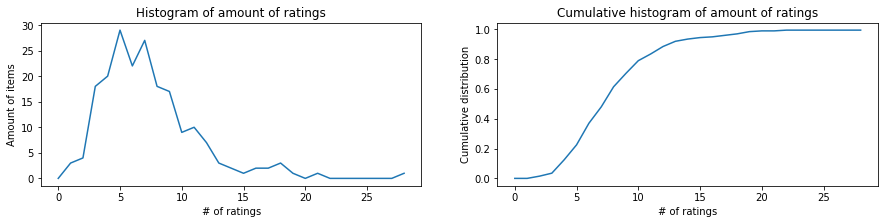

In [57]:
import matplotlib.pyplot as plt

itemRatings = ratings.apply(lambda x: np.sum(~np.isnan(x)), axis=1)
itemMaxRatings = itemRatings.max()

plt.figure(figsize=(15,3))
plt.subplot(121)

numRatingItems = []
for idx in range(itemMaxRatings + 1):
    numRatingItems.append(len(itemRatings[itemRatings == idx]))

plt.plot(numRatingItems)
plt.xlabel('# of ratings')
plt.ylabel('Amount of items')
plt.title('Histogram of amount of ratings')

plt.subplot(122)
cumulativeNumRatingItems = []
for idx in range(len(numRatingItems)):
    cumulativeNumRatingItems.append(np.sum(numRatingItems[:idx]))
    
cumulativeNumRatingItems = np.array(cumulativeNumRatingItems)

plt.plot(cumulativeNumRatingItems / ratings.shape[0])
plt.xlabel('# of ratings')
plt.ylabel('Cumulative distribution')
plt.title('Cumulative histogram of amount of ratings');